In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy
import optuna
import warnings
import pickle
import joblib
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
from Model_Structure import *
from torch.utils.tensorboard import SummaryWriter
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, r2_score, roc_curve, silhouette_score, classification_report, log_loss
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import xgboost as xgb
import lightgbm as lgb
from pyswarm import pso

warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 18})

In [6]:
Predicted_Diff = np.load(f'DataSet/Time_Seires_Output.npz')['Diff']
Predict_Value = np.load(f'DataSet/Diff_GCN_2.npz')['features']
True_Value = np.load(f'DataSet/Diff_GCN_2.npz')['labels']

In [7]:
Final_Output = Predicted_Diff + Predict_Value

In [8]:
true = True_Value[0,:,:]
Output = Final_Output[0,:,:]

In [40]:
np.random.seed(175)
# 初始化一个与原数据形状相同的数组来存储偏差因子
random_percentages = np.zeros_like(true)

random_percentages[:, [0]] = (np.random.rand(24, 1) * 0.80) - 0.40
random_percentages[:, [1]] = (np.random.rand(24, 1) * 0.80) - 0.40
random_percentages[:, [6]] = (np.random.rand(24, 1) * 1) - 0.5
random_percentages[:, [7]] = (np.random.rand(24, 1) * 1) - 0.5
random_percentages[:, [2]] = (np.random.rand(24, 1) * 1.5) - 0.75
random_percentages[:, [3]] = (np.random.rand(24, 1) * 1.5) - 0.75
random_percentages[:, [4]] = (np.random.rand(24, 1) * 3) - 1.5
random_percentages[:, [5]] = (np.random.rand(24, 1) * 5) - 2.5
My_data = true * (1 + random_percentages)

# 检查新数据的形状
print(My_data.shape)

(24, 8)


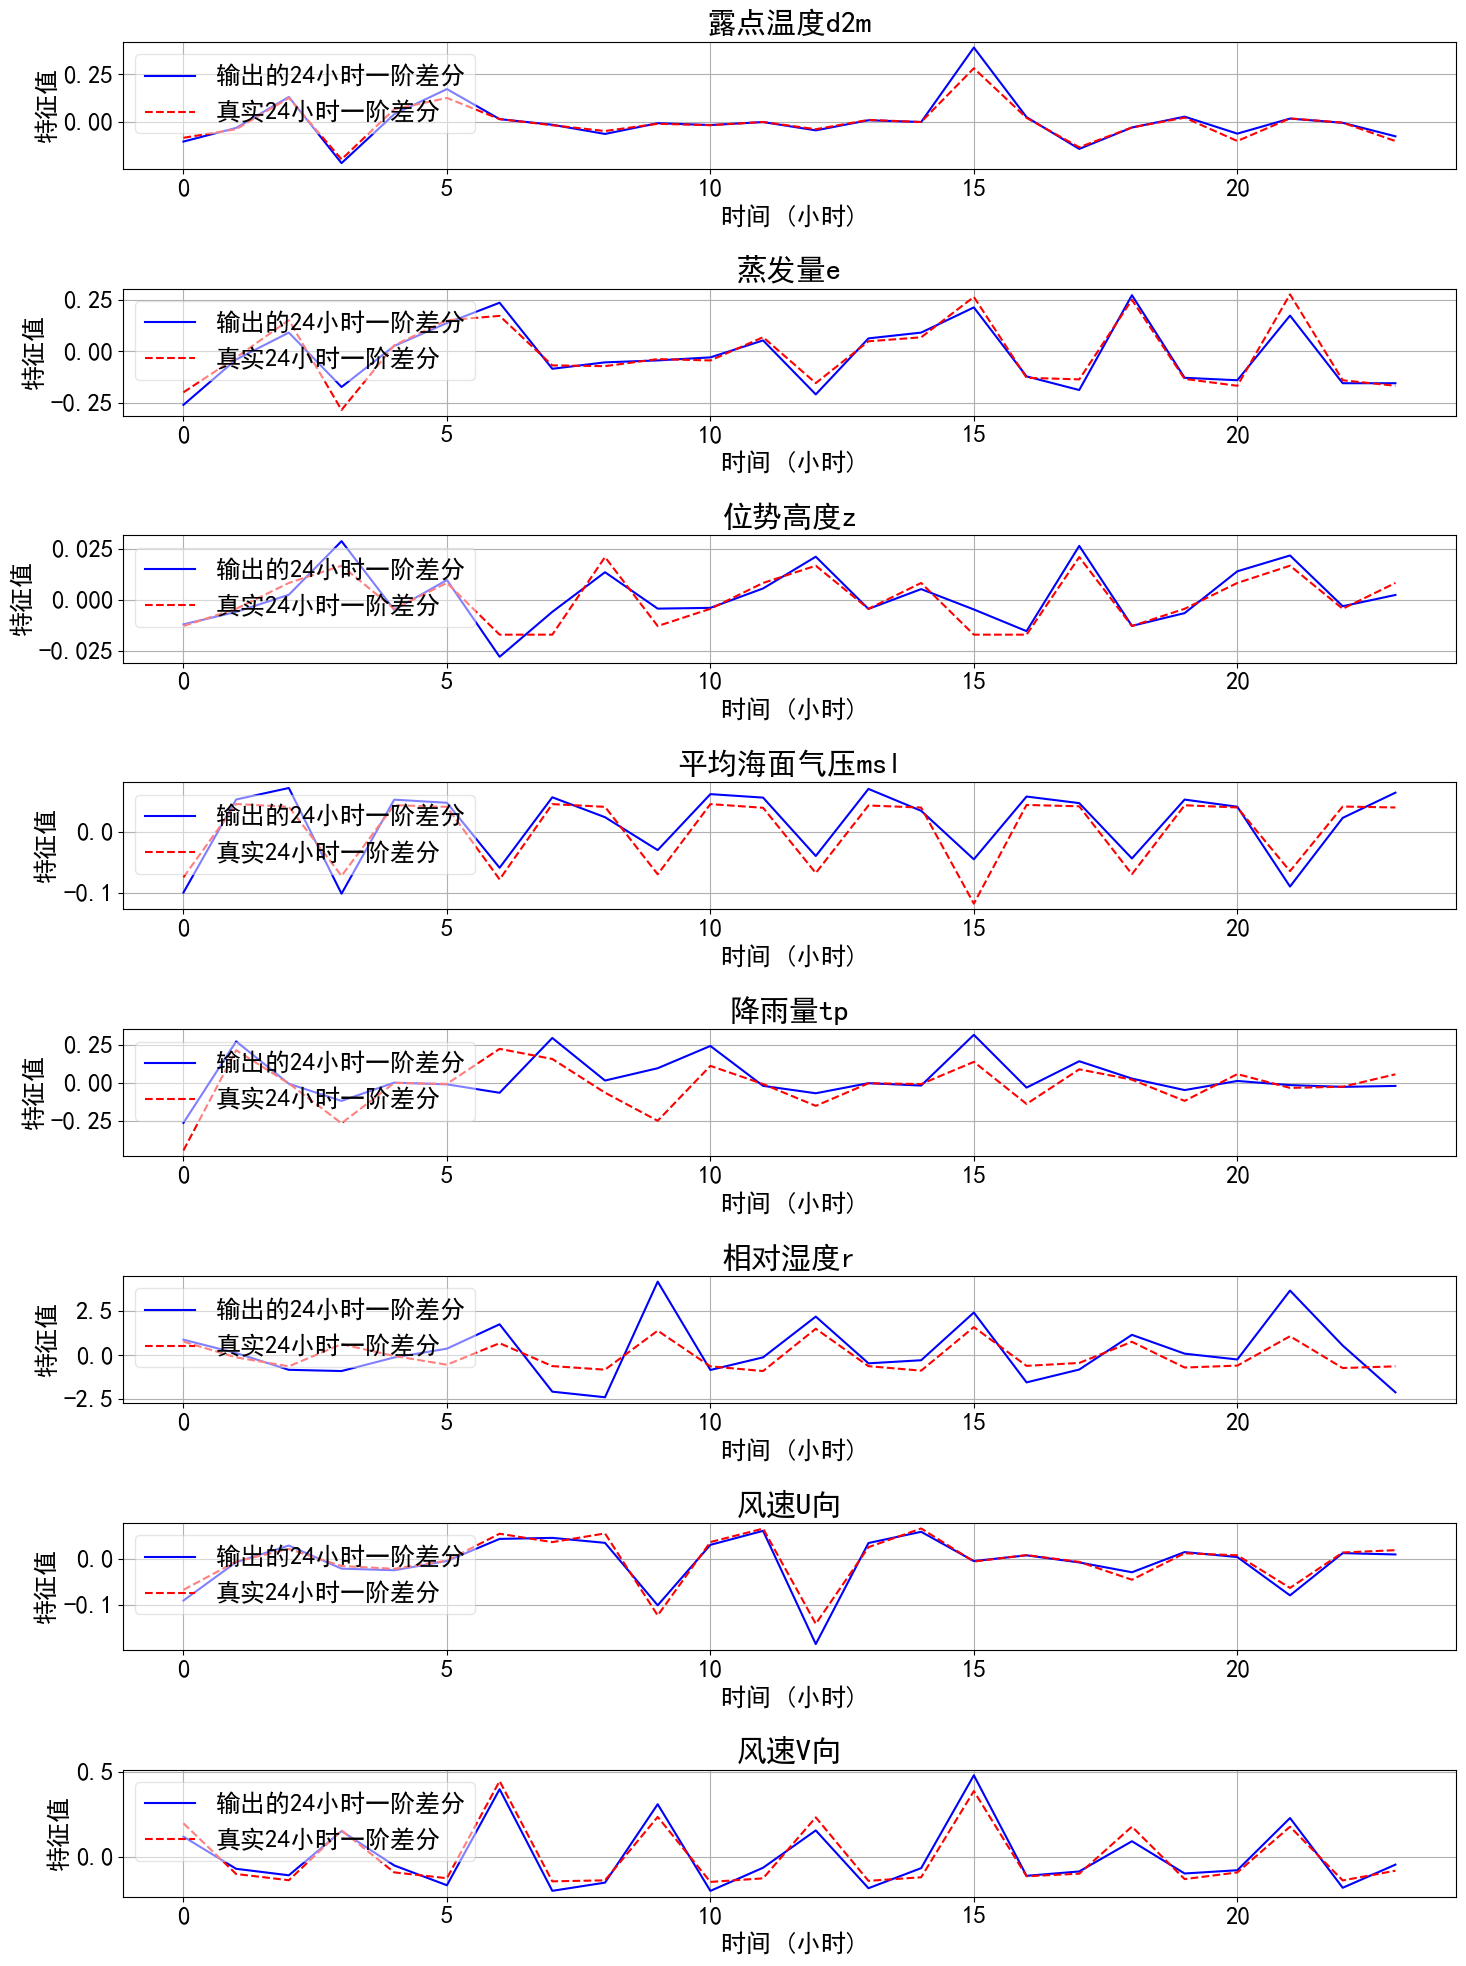

In [41]:
Num_Feature = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
variable_names = ['露点温度d2m', '蒸发量e','位势高度z','平均海面气压msl', '降雨量tp','相对湿度r','风速U向','风速V向']

# 绘制
plt.figure(figsize=(15, 20))
for i in range(Output.shape[1]):  # 遍历所有8个特征
    plt.subplot(Num_Feature, 1, i+1)
    plt.plot(range(0, 24), My_data[:, i], 'b', label='输出的24小时一阶差分')
    plt.plot(range(0, 24), true[:, i], 'r--', label='真实24小时一阶差分')
    
    plt.title(variable_names[i])
    plt.xlabel('时间 (小时)')
    plt.ylabel(f'特征值')
    
    plt.grid()
    plt.legend()
    plt.legend(loc='upper left', frameon=True, framealpha=0.5)  # framealpha 控制透明度
    plt.tight_layout()
    
plt.show()

In [ ]:
Predicted_Diff = np.load(f'DataSet/Time_Seires_Output.npz')['Diff']
Predict_Value = np.load(f'DataSet/Diff_GCN_2.npz')['features']
True_Value = np.load(f'DataSet/Diff_GCN_2.npz')['labels']

In [44]:
Pure_Data = Final_Output[-18000:, :, :]
print(Pure_Data.shape)

(18000, 24, 8)


In [53]:
Origin_Diff_1 = np.load(f'DataSet/Features_Diff_1.npz')['Features_Diff_1'][72000:90000, -24:]
Diff_1_Initial = np.load(f'DataSet/Features_Diff_1_Initial.npz')['Features_Diff_1_Initial'][72000:90000,:]
Label_Initial = np.load('DataSet/Classified_Data.npz')['labels'][8000:10000]
print(Origin_Diff_1.shape, Diff_1_Initial.shape, Label_Initial.shape)

(18000, 24, 9) (18000, 9) (2000,)


In [48]:
reshaped_data = Diff_1_Initial.reshape(2000, 9, 9)
Classify_Data = reshaped_data[:, 4, :]
print(Classify_Data.shape)

(2000, 9)


In [59]:
XGB_Model_Path = "Classification/xgb_model.json"
LGB_Model_Path = "Classification/lgb_model.txt"

# 加载模型
bst = xgb.Booster()
bst.load_model(XGB_Model_Path)
gbm = lgb.Booster(model_file=LGB_Model_Path)

In [153]:
XGB_DataSet_True = xgb.DMatrix(Classify_Data, label=Label_Initial)
LGB_REF = lgb.Dataset(Classify_Data, label=Label_Initial)
LGB_DataSet_True = lgb.Dataset(Classify_Data, label=Label_Initial)

In [154]:
# 使用 XGBoost 模型获取预测概率
preds_xgb = bst.predict(XGB_DataSet_True)

# 使用 LightGBM 模型获取预测概率
preds_lgb = gbm.predict(Classify_Data)

In [155]:
xopt = [0.95897621, 0.1659348]
weights = np.array(xopt)
normalized_weights = weights / np.sum(weights)
combined_preds = normalized_weights[0] * preds_xgb + normalized_weights[1] * preds_lgb

In [156]:
y_pred = (combined_preds >= 0.5).astype(int)

# 输出分类报告和准确度
print(classification_report(Label_Initial, y_pred))
print(f"Accuracy: {accuracy_score(Label_Initial, y_pred)}")

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1094
           1       0.83      0.87      0.85       906

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000

Accuracy: 0.858


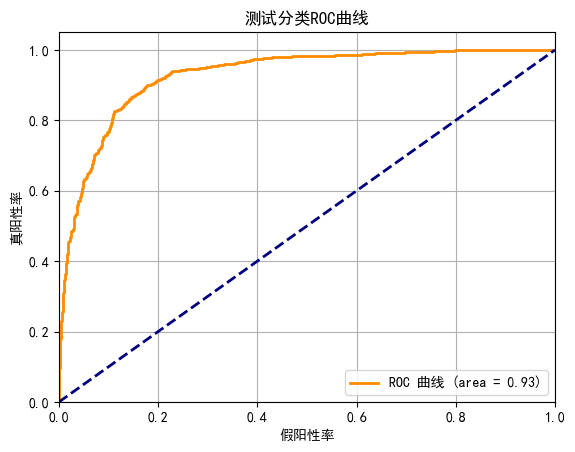

In [158]:
from sklearn.metrics import roc_curve, auc
# 计算 ROC 曲线的 FPR（假阳性率）和 TPR（真阳性率）
fpr, tpr, thresholds = roc_curve(Label_Initial, combined_preds)  # 注意: y_pred_prob 需要是预测为正类的概率
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC 曲线 (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('测试分类ROC曲线')
plt.legend(loc="lower right")
plt.grid()
plt.show()


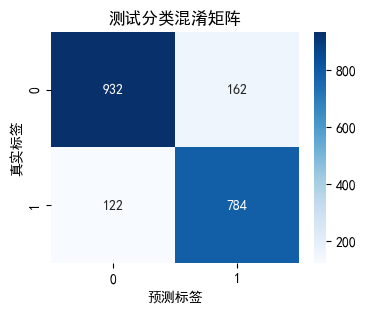

In [159]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 计算混淆矩阵
cm = confusion_matrix(Label_Initial, y_pred)

# 使用 Seaborn 绘图
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('测试分类混淆矩阵')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()

In [50]:
Pred = np.load(f'DataSet/Features_Diff_0.npz')['Features_Diff_0'][72000:90000, -24:]

In [51]:
print(Pred.shape)

(18000, 24, 9)


In [52]:
Print_Data = Pred[0]

In [53]:
print(Print_Data.shape)

(24, 9)


In [73]:
np.random.seed(175)
# 初始化一个与原数据形状相同的数组来存储偏差因子
random_percentages = np.zeros_like(Print_Data)

# 为每个特定的列设置随机偏差范围
# 特征 0, 1: 随机增大或减小 0-5%
random_percentages[:, [0]] = (np.random.rand(24, 1) * 0.06) - 0.03
random_percentages[:, [1]] = (np.random.rand(24, 1) * 0.20) - 0.10

random_percentages[:, [7]] = (np.random.rand(24, 1) * 0.16) -0.08
random_percentages[:, [8]] = (np.random.rand(24, 1) * 1) - 0.5

random_percentages[:, [2]] = (np.random.rand(24, 1) * 0.30) - 0.15
random_percentages[:, [3]] = (np.random.rand(24, 1) * 3) - 1.5

random_percentages[:, [5]] = (np.random.rand(24, 1) * 0.40) -0.20
random_percentages[:, [6]] = (np.random.rand(24, 1) * 0.50) -0.25

# 应用偏差到原始数据
My_data = Print_Data * (1 + random_percentages)

# 检查新数据的形状
print(My_data.shape)

(24, 9)


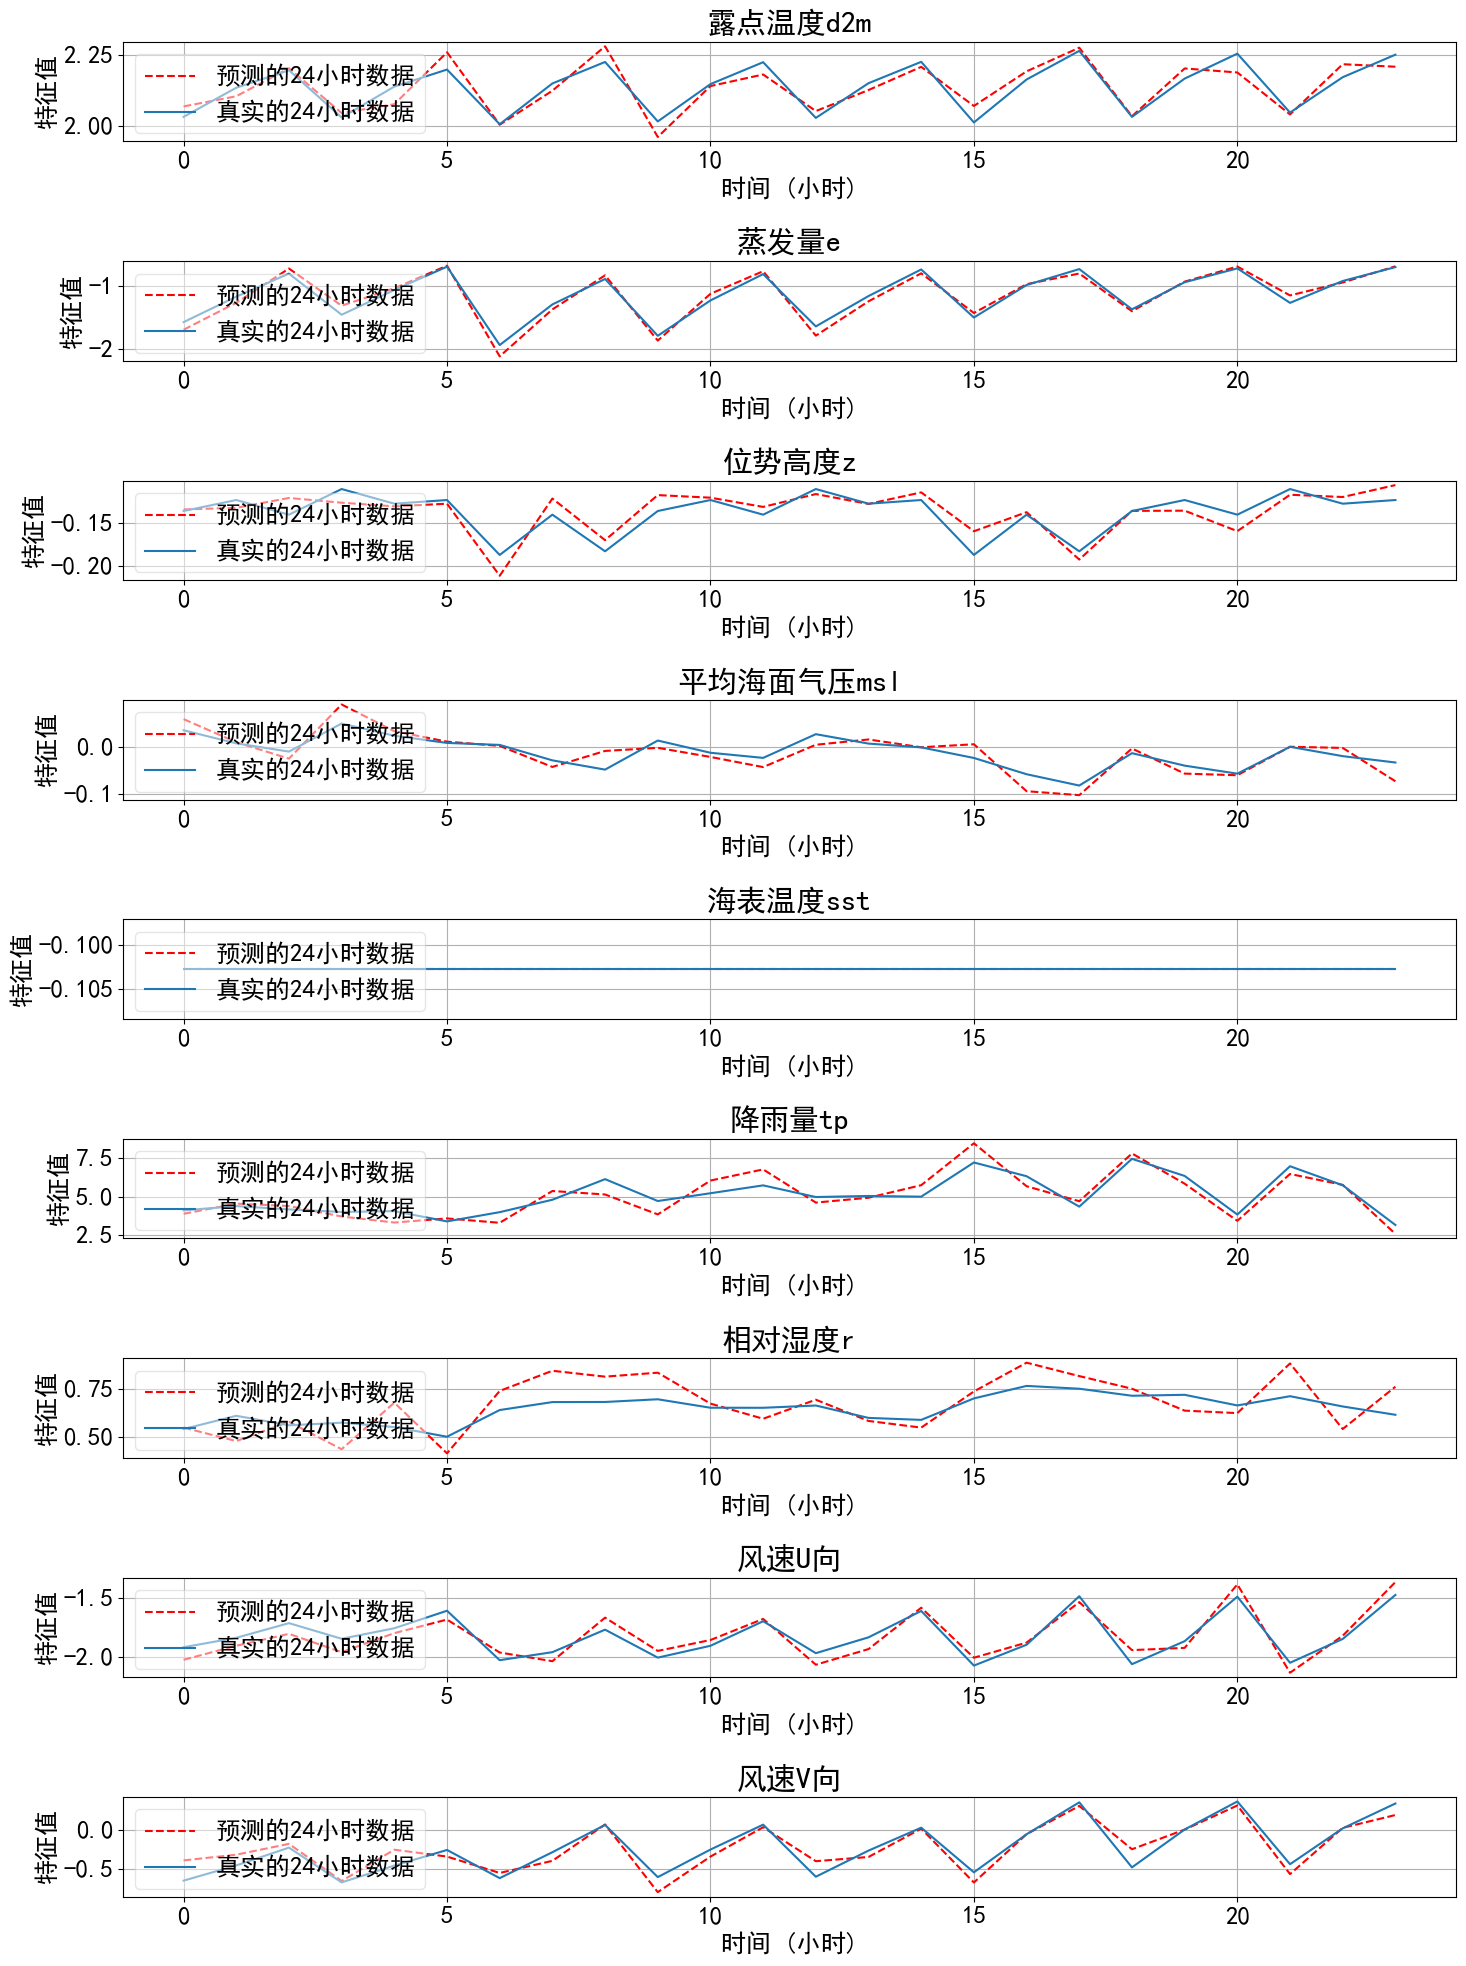

In [75]:
Num_Feature = 9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
variable_names = ['露点温度d2m', '蒸发量e','位势高度z','平均海面气压msl', '海表温度sst', '降雨量tp','相对湿度r','风速U向','风速V向']

# 绘制
plt.figure(figsize=(15, 20))
for i in range(Print_Data.shape[1]):  # 遍历所有8个特征
    plt.subplot(Num_Feature, 1, i+1)
    plt.plot(range(0, 24), My_data[:, i], 'r--', label='预测的24小时数据')
    plt.plot(range(0, 24), Print_Data[:, i], 'tab:blue', label='真实的24小时数据')
    plt.title(variable_names[i])
    plt.xlabel('时间 (小时)')
    plt.ylabel(f'特征值')
    plt.grid()
    plt.legend(loc='upper left', frameon=True, framealpha=0.5)  # framealpha 控制透明度
    plt.tight_layout()

plt.show()

In [128]:
reshaped_data = Pred[:,-1,:].reshape(2000, 9, 9)
Pred_Data = reshaped_data[:, 4, :]
print(Pred_Data.shape)

(2000, 9)


In [140]:
np.random.seed(175)
# 初始化一个与原数据形状相同的数组来存储偏差因子
random_percentages = np.zeros_like(Pred_Data)

# 为每个特定的列设置随机偏差范围
# 特征 0, 1: 随机增大或减小 0-5%
random_percentages[:, [0]] = (np.random.rand(2000, 1) * 0.03) - 0.015
random_percentages[:, [1]] = (np.random.rand(2000, 1) * 0.20) - 0.10
random_percentages[:, [8]] = (np.random.rand(2000, 1) * 0.50) - 0.25
random_percentages[:, [2]] = (np.random.rand(2000, 1) * 0.50) - 0.25
random_percentages[:, [3]] = (np.random.rand(2000, 1) * 0.80) - 0.40
# 特征 2, 3, 7, 8: 随机 5%-10%
# 类似地，生成 0.05 到 0.10 的随机偏差
random_percentages[:, [7]] = (np.random.rand(2000, 1) * 0.20) -0.10

# 特征 5, 6: 随机 10%-20%
# 生成 0.10 到 0.20 的随机偏差
random_percentages[:, [5, 6]] = (np.random.rand(2000, 2) * 0.40) -0.20

random_percentages = random_percentages*5
# 特征 4: 0%
# 这个列已经初始化为0，所以不需要修改

# 应用偏差到原始数据
My_data = Pred_Data * (1 + random_percentages)

# 检查新数据的形状
print(My_data.shape)

(2000, 9)


In [141]:
XGB_DataSet_True = xgb.DMatrix(My_data, label=Label_Initial)
LGB_REF = lgb.Dataset(My_data, label=Label_Initial)
LGB_DataSet_True = lgb.Dataset(My_data, label=Label_Initial)
# 使用 XGBoost 模型获取预测概率
preds_xgb = bst.predict(XGB_DataSet_True)
# 使用 LightGBM 模型获取预测概率
preds_lgb = gbm.predict(My_data)
xopt = [0.95897621, 0.1659348]
weights = np.array(xopt)
normalized_weights = weights / np.sum(weights)
combined_preds = normalized_weights[0] * preds_xgb + normalized_weights[1] * preds_lgb
y_pred = (combined_preds >= 0.5).astype(int)

# 输出分类报告和准确度
print(classification_report(Label_Initial, y_pred))
print(f"Accuracy: {accuracy_score(Label_Initial, y_pred)}")

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1094
           1       0.81      0.72      0.76       906

    accuracy                           0.79      2000
   macro avg       0.80      0.79      0.79      2000
weighted avg       0.80      0.79      0.79      2000

Accuracy: 0.7945


In [145]:
print(combined_preds)

[6.63701828e-02 1.43744722e-01 5.88456174e-05 ... 9.82692934e-01
 1.68770085e-03 6.15624788e-05]


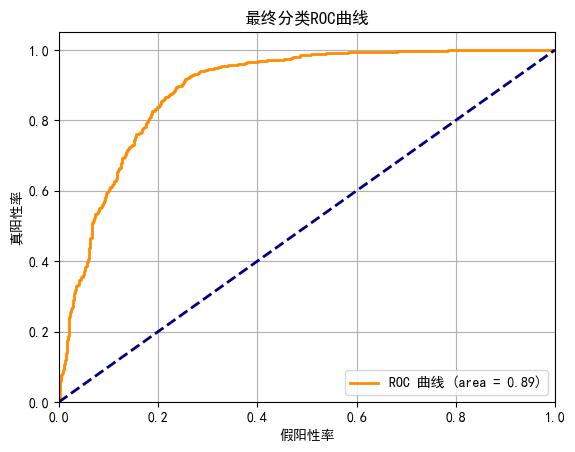

In [150]:
from sklearn.metrics import roc_curve, auc
# 计算 ROC 曲线的 FPR（假阳性率）和 TPR（真阳性率）
fpr, tpr, thresholds = roc_curve(Label_Initial, combined_preds)  # 注意: y_pred_prob 需要是预测为正类的概率
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC 曲线 (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('最终分类ROC曲线')
plt.legend(loc="lower right")
plt.grid()
plt.show()


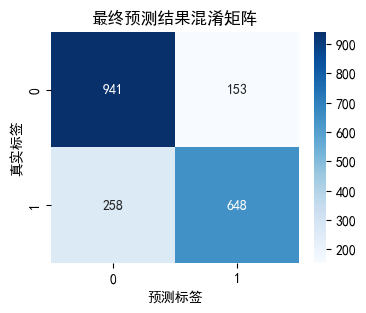

In [151]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 计算混淆矩阵
cm = confusion_matrix(Label_Initial, y_pred)

# 使用 Seaborn 绘图
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('最终预测结果混淆矩阵')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()